In [2]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

## Loading Data

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_set = datasets.MNIST(
    root="./Datasets",
    download=True,
    train=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)

test_set = datasets.MNIST(
    root='./Datasets',
    download=True,
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
)


## Creating DataLoader

In [4]:
# Defining DataLoader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

## The Model Class

In [6]:
# Fully Connected Neural Network Model
class Model(nn.Module):
    def __init__(self, in_features, hidden_size, out_classes):
        super(Model, self).__init__()
        # Input Layer -> Hidden Layer -> Softmax Layer
        self.fully_connected1 = nn.Linear(in_features, hidden_size)
        self.fully_connected2 = nn.Linear(hidden_size, out_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        # The Forward Pass
        linear1 = self.fully_connected1(x)
        relu1 = self.relu(linear1)
        linear2 = self.fully_connected2(relu1)
        softmax = self.softmax(linear2)

        return softmax


In [7]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images.reshape(-1, 28 * 28))
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [8]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs.reshape(-1, 28 * 28))
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
    
  return loss.item(), acc / length

In [11]:
# Defining hyperparameters
hparams = {'batch_size': 256, 'learning_rate': 2e-3, 'epochs': 15}

# Defining model
model = Model(in_features=28*28, hidden_size=256, out_classes=10)
model.to(device)

# Defining optimizer
optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'])

# Defining loss
criterion = nn.CrossEntropyLoss()

# model summary
summary(model, (1, 28*28), batch_size=hparams['batch_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [256, 1, 256]         200,960
              ReLU-2              [256, 1, 256]               0
            Linear-3               [256, 1, 10]           2,570
           Softmax-4               [256, 1, 10]               0
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 1.04
Params size (MB): 0.78
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


In [10]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]
  
  # just a way to avoid overfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

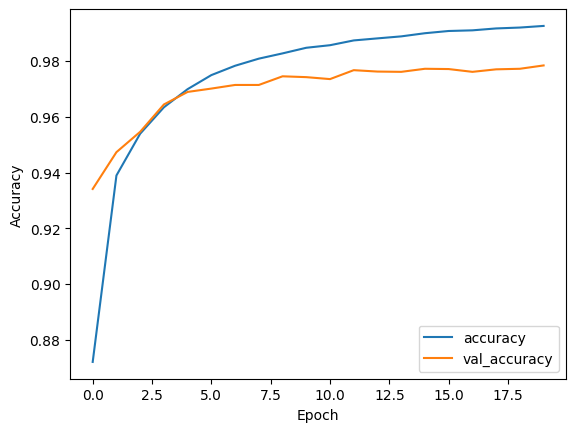

In [12]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [13]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

(0.09640000015497208, 0.09956666827201843)